In [92]:
#import for data manipulation
import pandas as pd
import numpy as np

#import for plots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder   #convert categorical values to numercial instead of using one encoding 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#import for model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


#saving the model
import pickle

import warnings
warnings.filterwarnings("ignore")

In [93]:
df = pd.read_csv('/Users/jamiekanagasundram/Documents/concordia-bootcamps/Git_hub folder/Capstone project/data/carclaims.csv')

# Check for missing values
print(df.isnull().sum())

# Check for duplicates
print(df.duplicated().sum())

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days:Policy-Accident    0
Days:Policy-Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange-Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
FraudFound              0
dtype: int64
0


In [68]:
#choosing the columns we want to look at

columns_to_look_at = ['Month', 'Make', 'AccidentArea','MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
           'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory','VehiclePrice',
           'Deductible','DriverRating','PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
           'PoliceReportFiled', 'WitnessPresent', 'AgentType','NumberOfSuppliments', 
           'AddressChange-Claim', 'NumberOfCars','BasePolicy', 'FraudFound', 'DriverRating']

In [69]:
# created a function to make pie charts instead of repeating this 

def create_pie_chart(df, column_name):
    """
    This function takes a DataFrame and the name of a column as inputs, and creates a pie chart
    of the value counts of that column using Plotly Express.
    """
    counts = df[column_name].value_counts()
    fig = px.pie(values=counts, names=counts.index, color_discrete_sequence=px.colors.sequential.Greens, title=column_name)
    fig.show()

In [3]:
#now were passing all the columns in the df into the fucntion to have a visual of the tendency of the data , commented because I used it in the app
# for i in columns_to_look_at:
#     create_pie_chart(df, i)
    



**Patterns in the claims by the columns**

Most common claims incident happened in Jan? Winter? 
Most common make in claims is a Pontiac      (correlation between the make and fraud?)  divide by low end mid end and high end car? 

Most claims were in Urban areas
Most claims were made by men
Most claims were by people who identified as married

**make a box plot for age   or drop it since we have the column with age by ranges 

Most claims were policy holder fault    (correlation between who was at fault and fraud?)
Most claims were sedans        (correlation between the type and fraud?)
Most claims were for vehicles between the price of $20,000 - $29,000 (correlation between car price and fraud?)
Most of the claims were for policies with a $400 deductible 

**Claims for driver rating came in even ( could posibly drop this)

Most claims happened when the policy holder had had the policy longer than 30 days

Most number of claims came from indivuduals who have 2-4 prior claims  (so if you have 2-4 claims youre more like to make a claim?  how would this relate to fraud)

Most claims came for vehicles that were 7 years old and then vehicles older than 7 years

Most claims came from drivers aged 31-35.  (see how this coloumn relates to fraud)

Most claims did not have a police report files (of which are yes how many were fraudulent??)

Most claims did not have a witness present (of which are yes how many were fraudulent??)

Most claims had no other supplimentary policies (of which how many were fraudulent??)

Most claims came from drivers with 1 vehicle 

Most claims came from drivers in a collision over liability or all perils claim 

Lastly this data set contains claims that were only 6% fraudulent, now of the 6% we need to find patterns 


In [70]:
#pie chart showing patterns in the fraud claims , commented because I used it in the app
# for i in columns_to_look_at:
fraud_found_data = df[df['FraudFound']== 'Yes']

# for i in columns_to_look_at:
#     create_pie_chart(fraud_found_data, i)

**Looking at just the fraud claims**

Most fraud claims happened in March

Most fraud claims included a pontiac

Most fraud claims happened in urban areas

Most fraud claims were claimed in May

Most fraud claims came from males

Most fraud claims came from individual who were considered as married 

Most fraud claims came from policy holders

Most fraud claims came from sedans

Most fraud claims came from vehicles priced between $20,000 - $29,000 second were vehicles over $69,000

Most fraud claims came from policy holders with a $400 deductible

Most fraud claims came from individual with no prior claims and second were ones with 2-4 claims 

Most fraud claims came from vehicles that were 7 years old

Most fraud claims came from individuals who were 31-35 

Most fraud claims came from individuals who have 1 vehicle

Most fraud claims came from all perils or collision 


**Remove unnecessary columns**

In [94]:
#based on the pie charts we can remove some columns we dont need 
df.drop(['PolicyType', 'RepNumber','PolicyNumber','AgentType', 'AddressChange-Claim','Days:Policy-Accident','Days:Policy-Claim','PoliceReportFiled', 'WitnessPresent','NumberOfSuppliments','NumberOfCars','AgeOfPolicyHolder'], axis=1, inplace=True)  #dont need these columns

**Assign numerical values to categorical data**

In [95]:
df = df.replace({
    'FraudFound': {'Yes': 1, 'No': 0},
    'AccidentArea': {'Urban': 1, 'Rural': 0},
    'Sex': {'Male': 1, 'Female': 0},
    'Fault': {'Third Party': 0, 'Policy Holder': 1}
})

**Create a column for the number of days between the accident date and claim date**

In [96]:
# Convert Year, Month, and DayOfWeek columns to strings and concatenate them into a single string for accident date
date_str = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayOfWeek'].astype(str)

# Convert date string to datetime format and add offset based on week of month
df['Accident_Date'] = pd.to_datetime(date_str, format='%Y-%b-%A') + pd.to_timedelta((df['WeekOfMonth']-1)*7, unit='d')

# Drop original date columns
df.drop(['Month', 'WeekOfMonth', 'DayOfWeek'], axis=1, inplace=True)



In [97]:
#drop the 1 column that has month as a 0
df.drop(index=df[df['MonthClaimed'] == '0'].index, inplace=True)

In [98]:
# Convert Year, Month, and DayOfWeek columns to strings and concatenate them into a single string for accident date
date_str = df['Year'].astype(str) + '-' + df['MonthClaimed'].astype(str) + '-' + df['DayOfWeekClaimed'].astype(str)

# Convert date string to datetime format and add offset based on week of month
df['Claim_Date'] = pd.to_datetime(date_str, format='%Y-%b-%A') + pd.to_timedelta((df['WeekOfMonthClaimed']-1)*7, unit='d')

df.drop(['MonthClaimed', 'WeekOfMonthClaimed', 'DayOfWeekClaimed'], axis=1, inplace=True)

In [99]:
#create columns that counts the number of days
df['Days_Accident_to_Claim'] = df['Claim_Date']-df['Accident_Date']
df['Days_Accident_to_Claim'] = (df['Days_Accident_to_Claim'].dt.total_seconds().astype(int))//(24*3600)  #convert column to int type to add 365 
df['Days_Accident_to_Claim'] = df['Days_Accident_to_Claim'].apply(lambda x: x+365 if x<0 else x)  #adding 365 to negative columns since a claim cant be filed before an accident 

**Create a season category**


In [100]:
# create a function to categorize dates into seasons
def get_season(date):
    """
    This function takes a date in the format year-month-day and assingns it a season based on the given rages 
    Winter: Dec 22nd - March 19th
    Spring: March 20th - June 20th
    Summer: June 21st - Sept 22
    Fall: Sept 23 - Dec 21st
    """
    if (date.month == 12 and date.day >= 22) or (date.month == 3 and date.day < 20) or (date.month == 1 and date.day >= 1) or (date.month == 2):
        return 'Winter'
    elif (date.month == 3 and date.day >= 20) or (date.month == 6 and date.day < 21) or (date.month == 4 or date.month == 5):
        return 'Spring'
    elif (date.month == 6 and date.day >= 21) or (date.month == 9 and date.day < 22) or (date.month == 7 or date.month == 8):
        return 'Summer'
    elif (date.month == 9 and date.day >= 22) or (date.month == 12 and date.day < 22) or (date.month == 10 or date.month == 11):
        return 'Fall'

df['Season'] = df['Accident_Date'].apply(get_season)

df.drop(['Accident_Date', 'Claim_Date'], axis=1, inplace=True)  #dropping the rows we created prior since we dont need it anymore

**Create a column that marks a car based on its make, price and category as lux ,mid, reg**

In [101]:
def get_car_label(row):
    """
    This function takes the row info of a claim: the make, vehicle price, and vehicle 
    category and labels it as a luxury car, mid or regular in a new column
    """
    
    luxury_makes = ['Jaguar', 'Porche', 'BMW', 'Mercedes', 'Ferrari', 'Lexus']
    mid_makes = ['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac', 'Accura','Dodge','Mercury', 'Nisson', 'VW', 'Saab', 'Saturn']
    
    if row['Make'] in luxury_makes:
        return 'luxury'
    if row['Make'] in mid_makes: 
        if row['VehiclePrice'] == ['60,000 to 69,000', 'more than 69,000']:
            return 'High-End Mid-Range'
    
        if row['VehiclePrice'] in ['40,000 to 59,000','30,000 to 39,000']:
            return 'Mid-Range'
  
        if row['VehiclePrice'] in ['20,000 to 29,000','less than 20,000']:
            return 'Economy Cars'
        
        else :
            return 'High-End Mid-Range'
        
        
# create a new column with car labels
df['CarLabel'] = df.apply(get_car_label, axis=1)

**Driver rating and sex**

In [102]:
def quality_of_driver(df):
    """
    This function takes the row info of a claim: driver rating and sex and labels a new row as either:
    Male poor , Male good, Female poor , Female good 
    """
    
    if (df['Sex']== 1) & (df['DriverRating'] <= 2):
        return 'Male - good'
    elif (df['Sex']== 1) & (df['DriverRating'] >2):
        return 'Male - poor'
    elif (df['Sex']== 0) & (df['DriverRating'] <= 2):
        return 'Female - good'
    elif (df['Sex']== 0) & (df['DriverRating'] >2):
        return 'Female - poor'
    
# create a new column with car labels
df['Good/Poor_Driver'] = df.apply(quality_of_driver, axis=1)

df

,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,VehicleCategory,VehiclePrice,Deductible,DriverRating,PastNumberOfClaims,AgeOfVehicle,Year,BasePolicy,FraudFound,Days_Accident_to_Claim,Season,CarLabel,Good/Poor_Driver
0,Honda,1,0,Single,21,1,Sport,"more than 69,000",300,1,none,3 years,1994,Liability,0,3,Winter,High-End Mid-Range,Female - good
1,Honda,1,1,Single,34,1,Sport,"more than 69,000",400,4,none,6 years,1994,Collision,0,7,Winter,High-End Mid-Range,Male - poor
2,Honda,1,1,Married,47,1,Sport,"more than 69,000",400,3,1,7 years,1994,Collision,0,10,Fall,High-End Mid-Range,Male - poor
3,Toyota,0,1,Married,65,0,Sport,"20,000 to 29,000",400,2,1,more than 7,1994,Liability,0,23,Spring,Economy Cars,Male - good
4,Honda,1,0,Single,27,0,Sport,"more than 69,000",400,1,none,5 years,1994,Collision,0,10,Winter,High-End Mid-Range,Female - good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Toyota,1,1,Married,35,1,Sedan,"20,000 to 29,000",400,4,2 to 4,6 years,1996,Collision,1,7,Fall,Economy Cars,Male - poor
15416,Pontiac,1,1,Married,30,1,Sport,"30,000 to 39,000",400,3,more than 4,6 years,1996,Liability,0,2,Fall,Mid-Range,Male - poor
15417,Toyota,0,1,Single,24,1,Sedan,"20,000 to 29,000",400,4,more than 4,5 years,1996,Collision,1,2,Fall,Economy Cars,Male - poor
15418,Toyota,1,0,Married,34,0,Sedan,"20,000 to 29,000",400,4,none,2 years,1996,All Perils,0,7,Fall,Economy Cars,Female - poor


In [103]:
#transform categorical values to numerical values 
le = LabelEncoder()
cols = df.select_dtypes('O').columns
df[cols]= df[cols].apply(le.fit_transform) #convert object types to numerical data

df

,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,VehicleCategory,VehiclePrice,Deductible,DriverRating,PastNumberOfClaims,AgeOfVehicle,Year,BasePolicy,FraudFound,Days_Accident_to_Claim,Season,CarLabel,Good/Poor_Driver
0,6,1,0,2,21,1,1,5,300,1,3,1,1994,2,0,3,3,1,0
1,6,1,1,2,34,1,1,5,400,4,3,4,1994,1,0,7,3,1,3
2,6,1,1,1,47,1,1,5,400,3,0,5,1994,1,0,10,0,1,3
3,17,0,1,1,65,0,1,0,400,2,0,6,1994,2,0,23,1,0,2
4,6,1,0,2,27,0,1,5,400,1,3,3,1994,1,0,10,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,17,1,1,1,35,1,0,0,400,4,1,4,1996,1,1,7,0,0,3
15416,13,1,1,1,30,1,1,1,400,3,2,4,1996,2,0,2,0,2,3
15417,17,0,1,2,24,1,0,0,400,4,2,3,1996,1,1,2,0,0,3
15418,17,1,0,1,34,0,0,0,400,4,3,0,1996,0,0,7,0,0,1


In [104]:
#save preprocessed df as a csv
df.to_csv('my_preprocessed_data.csv', index=False)

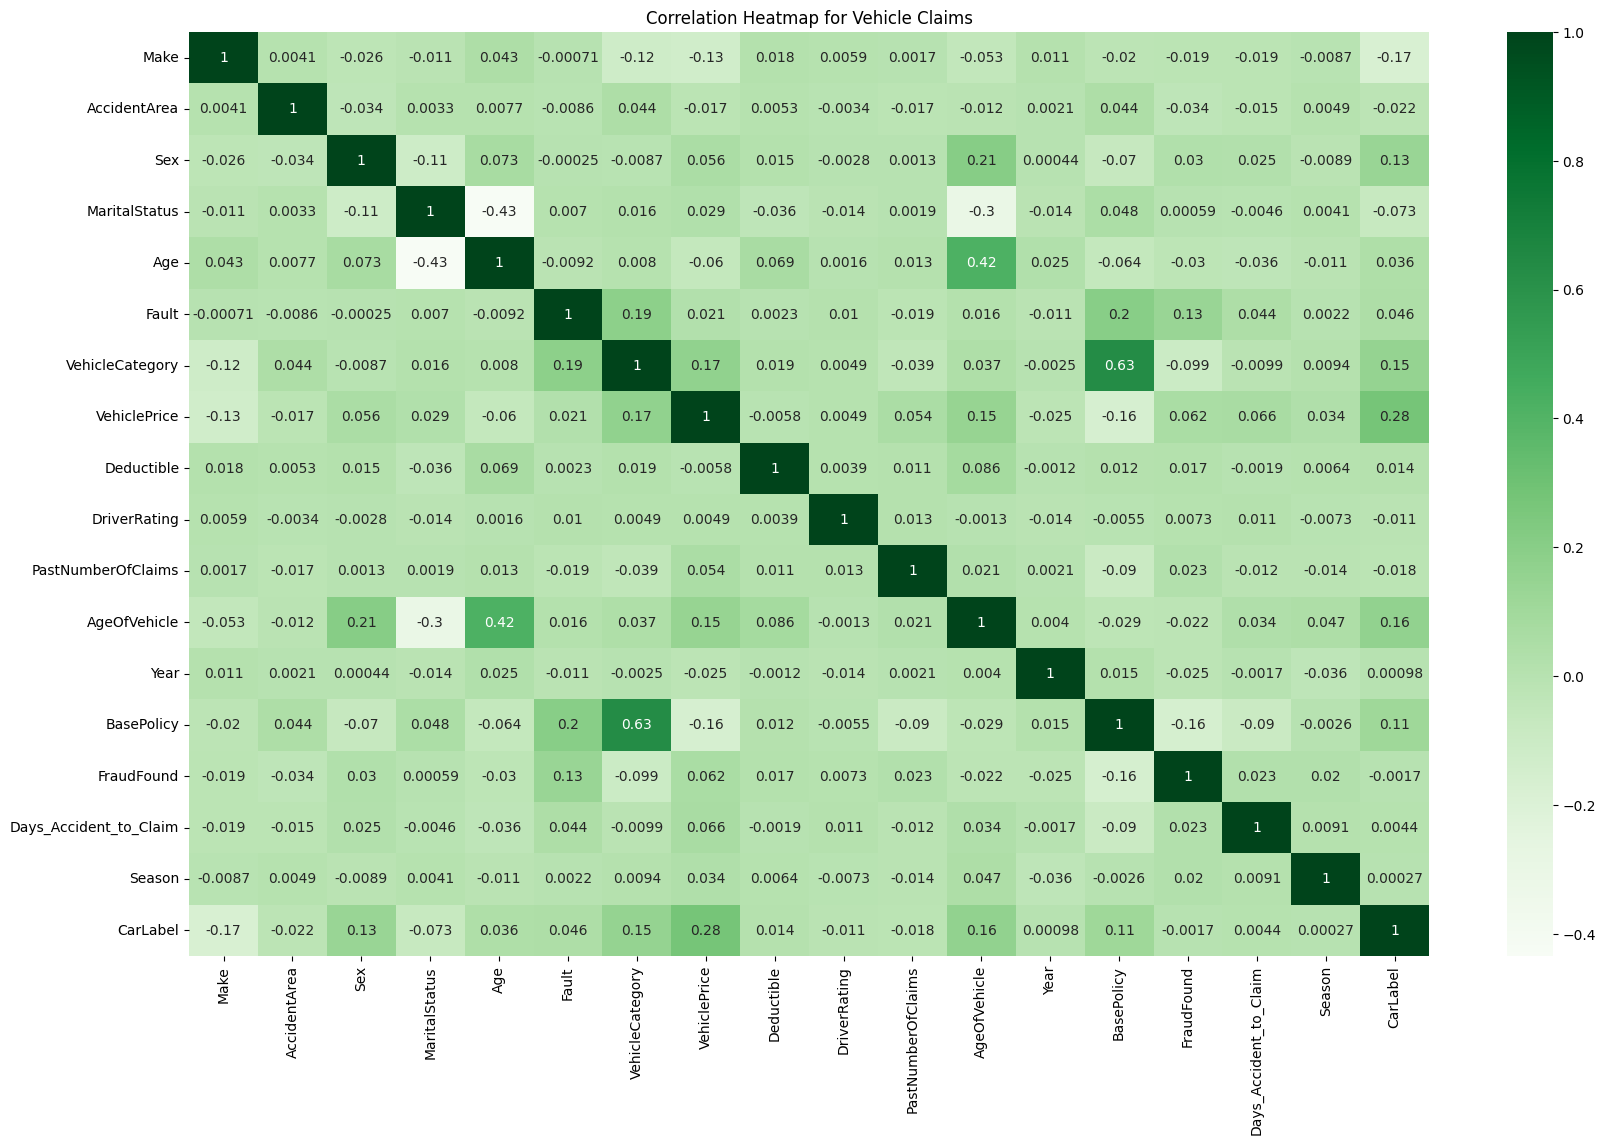

In [35]:
#create a heat map

plt.figure(figsize=(20,12))
sns.heatmap(df.corr(),cmap="Greens",annot=True)
plt.title("Correlation Heatmap for Vehicle Claims")
plt.show()

**Looking at the heat map there some relationships between the following:** 

Month & Month Claimed

Sex & Age of vehicle

Vehicle categorie & Base Policy 

Vehicle price &  Age of vehicle

Age of vehicle & Age of policy holder

Vehicle Price & Driver Type


**Random Forest** 
- is effective algorithm for classification tasks, can handle both numerical and categorical features. 
- ability to handle imbalanced datasets
- works by building multiple decision trees and aggregating their predictions, which can lead to better performance and reduce overfitting.


**Unbalanced set**

Stratify parameter ensures that the class distribution in the original dataset is preserved in both the training and testing sets. This is achieved by allocating samples from each class in the same proportion to the training and testing sets.

**SMOTE**

In [105]:
# Separate majority and minority classes
df_majority = df[df.FraudFound==0]
df_minority = df[df.FraudFound==1]

# Upsample the minority class using SMOTE 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.drop('FraudFound', axis=1), df['FraudFound'])

# Combine majority class with synthetic minority class
df_synthetic = pd.DataFrame(X_res, columns=df.columns[:-1])
df_synthetic['FraudFound'] = y_res

# Split the upsampled data into training and testing sets
X = df_synthetic.drop('FraudFound', axis=1)
y = df_synthetic['FraudFound']
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y, test_size=0.2, random_state=42)


In [106]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier()

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2900
           1       0.94      0.97      0.95      2899

    accuracy                           0.95      5799
   macro avg       0.95      0.95      0.95      5799
weighted avg       0.95      0.95      0.95      5799



- Separate the input data into two groups based on the target variable 'FraudFound'. The first group contains instances where 'FraudFound' is equal to 0 (non-fraudulent claims), and the second group contains instances where 'FraudFound' is equal to 1 (fraudulent claims).

- Upsample the minority class (fraudulent claims) using SMOTE. This creates synthetic samples by generating new instances that are similar to the minority class instances. This helps the unbalanced data set.

- Combine the majority class (non-fraudulent claims) with the synthetic minority class to form a new dataset.

- Split the new dataset into training and testing sets, 80% is used for training the model, and 20% is used for testing the model. The stratify parameter is set to the target variable (y) to ensure that the proportion of classes is the same in the training and testing sets.

- Train using Random Forest on an upsampled dataset using SMOTE to handle class imbalance. 

- Use the trained model to make predictions on the testing set. Evaluate the performance of the model, measure the accuracy, precision, recall, and F1-score of the model's predictions. These measures indicate how well the model has predicted the fraudulent claims compared to the non-fraudulent claims.

**Results of model**

the overall **accuracy** is 0.95

the **F1-score** for class "0" - non fraud is 0.95 and F1-score for class "1" - fraud  is 0.95, which indicates high accuracy and consistency in predicting this class, 

for class "0" - non fraud, the **precision** is 0.97, which means that when the model predicts a sample as "0", it is correct 97% of the time. For class "1" - fraud, the precision is 0.94, indicating that 94% of the samples predicted as "1" are actually true positives.

In [38]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with the parameter grid and the Random Forest model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training set
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/Users/jamiekanagasundram/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jamiekanagasundram/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/jamiekanagasundram/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

Best parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.9393782544285605


we define a parameter grid for random forest model. We then create a GridSearchCV object and fit it to the training data. Finally, we print the best parameters and the corresponding score. Then modify the parameter grid to include other parameters, and adjust the number of cross-validation folds (cv) to improve the performance estimate.

In [107]:
# Initialize the Random Forest model with the new parameters found using grid search
rf_model = RandomForestClassifier(max_depth = None, max_features = 'auto' , min_samples_leaf = 1 , min_samples_split = 2, n_estimators =  100)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2900
           1       0.94      0.97      0.95      2899

    accuracy                           0.95      5799
   macro avg       0.95      0.95      0.95      5799
weighted avg       0.95      0.95      0.95      5799



**Results of model after hyppertuning parameters**

The results stayed the same, lets try cross validating to see if its consistent.


In [40]:
# Cross-validate the model
scores = cross_val_score(rf_model, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.85549233 0.92964304 0.92048982 0.95429458 0.95050017]
Mean cross-validation score: 0.92


In [41]:
# Cross-validate the model
scores = cross_val_score(rf_model, X, y, cv=10)

# Print the cross-validation scores
print("Cross-validation scores: {}".format(scores))
print("Mean cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.79551724 0.94793103 0.94687823 0.94998275 0.94411866 0.94549845
 0.93756468 0.97688858 0.97895826 0.98378751]
Mean cross-validation score: 0.94


function will split the data into 5 folds, train the model on 4 folds, and test it on the remaining fold. It will repeat this process 5 times, so that each fold is used as a test set once. The function returns an array of scores, one for each fold.

**Precision-Recall curve**

Precision-Recall curves should be used when there is a moderate to large class imbalance.

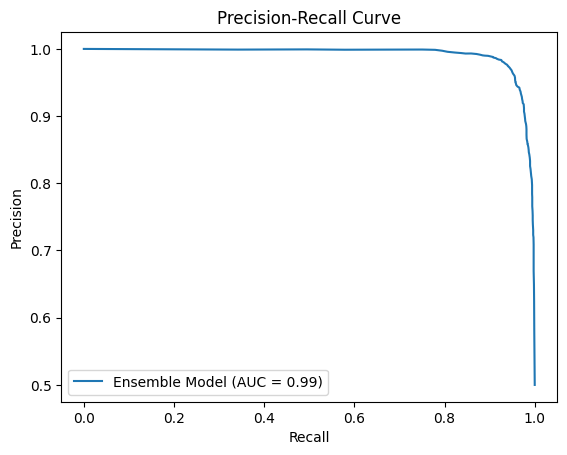

In [42]:
# Predict probabilities for the test set
y_score = rf_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# Calculate the area under the precision-recall curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Ensemble Model (AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

Large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives. It is only concerned with the correct prediction of the minority class, class 1.

A **precision-recall** curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds, much like the ROC curve.


Model has a very good performance in distinguishing between positive and negative samples. AUC values range from 0 to 1, with a value of 0.5 indicating a random classifier and a value of 1 indicating a perfect classifier. 

**Saving the model**

In [108]:
filename = "Trained_Model.sav"
pickle.dump(rf_model, open(filename,'wb'))


In [109]:
#loading the saved model
loaded_model = pickle.load(open('Trained_Model.sav','rb'))

In [110]:
y_pred = loaded_model.predict(X_test)

# Evaluate the performance of the ensemble model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2710  190]
 [  86 2813]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2900
           1       0.94      0.97      0.95      2899

    accuracy                           0.95      5799
   macro avg       0.95      0.95      0.95      5799
weighted avg       0.95      0.95      0.95      5799



**Build and Test the Prediction Function**

This will be used in the streamlit dashboard where the inputs of the user will be taken into acocunt to predict if the claim is fraudulent or not.

In [114]:

#creating a function for prediction
def predict(Month, WeekOfMonth, DayOfWeek, Make, AccidentArea,DayOfWeekClaimed, 
MonthClaimed, WeekOfMonthClaimed, Sex,MaritalStatus, Age, Fault, VehicleCategory, 
VehiclePrice,Deductible, DriverRating, PastNumberOfClaims, AgeOfVehicle,Year,BasePolicy):

    df = pd.DataFrame([[Month, WeekOfMonth, DayOfWeek, Make, AccidentArea,DayOfWeekClaimed, MonthClaimed, WeekOfMonthClaimed, 
    Sex,MaritalStatus, Age, Fault, VehicleCategory, VehiclePrice,Deductible, DriverRating, PastNumberOfClaims, AgeOfVehicle,
    Year,BasePolicy]], columns=['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea','DayOfWeekClaimed', 'MonthClaimed', 
    'WeekOfMonthClaimed', 'Sex','MaritalStatus', 'Age', 'Fault', 'VehicleCategory', 'VehiclePrice','Deductible', 'DriverRating', 
    'PastNumberOfClaims', 'AgeOfVehicle','Year', 'BasePolicy'])

    df = df.replace({
    'AccidentArea': {'Urban': 1, 'Rural': 0},
    'Sex': {'Male': 1, 'Female': 0},
    'Fault': {'Third Party': 0, 'Policy Holder': 1}
    })

    # Convert Year, Month, and DayOfWeek columns to strings and concatenate them into a single string for accident date
    date_str = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayOfWeek'].astype(str)

    # Convert date string to datetime format and add offset based on week of month
    df['Accident_Date'] = pd.to_datetime(date_str, format='%Y-%b-%A') + pd.to_timedelta((df['WeekOfMonth']-1)*7, unit='d')

    # Drop original date columns
    df.drop(['Month', 'WeekOfMonth', 'DayOfWeek'], axis=1, inplace=True)

    #drop the 1 column that has month as a 0
    df.drop(index=df[df['MonthClaimed'] == '0'].index, inplace=True)

    # Convert Year, Month, and DayOfWeek columns to strings and concatenate them into a single string for accident date
    date_str = df['Year'].astype(str) + '-' + df['MonthClaimed'].astype(str) + '-' + df['DayOfWeekClaimed'].astype(str)

    # Convert date string to datetime format and add offset based on week of month
    df['Claim_Date'] = pd.to_datetime(date_str, format='%Y-%b-%A') + pd.to_timedelta((df['WeekOfMonthClaimed']-1)*7, unit='d')

    df.drop(['MonthClaimed', 'WeekOfMonthClaimed', 'DayOfWeekClaimed'], axis=1, inplace=True)


    #create columns that counts the number of days
    df['Days_Accident_to_Claim'] = df['Claim_Date']-df['Accident_Date']
    df['Days_Accident_to_Claim'] = (df['Days_Accident_to_Claim'].dt.total_seconds().astype(int))//(24*3600)  #convert column to int type to add 365 
    df['Days_Accident_to_Claim'] = df['Days_Accident_to_Claim'].apply(lambda x: x+365 if x<0 else x)  #adding 365 to negative columns since a claim cant be filed before an accident 


    # create a function to categorize dates into seasons
    def get_season(date):
        if (date.month == 12 and date.day >= 22) or (date.month == 3 and date.day < 20) or (date.month == 1 and date.day >= 1) or (date.month == 2):
            return 'Winter'
        elif (date.month == 3 and date.day >= 20) or (date.month == 6 and date.day < 21) or (date.month == 4 or date.month == 5):
            return 'Spring'
        elif (date.month == 6 and date.day >= 21) or (date.month == 9 and date.day < 22) or (date.month == 7 or date.month == 8):
            return 'Summer'
        elif (date.month == 9 and date.day >= 22) or (date.month == 12 and date.day < 22) or (date.month == 10 or date.month == 11):
            return 'Fall'

    df['Season'] = df['Accident_Date'].apply(get_season)
    df.drop(['Accident_Date', 'Claim_Date'], axis=1, inplace=True)  #dropping the rows we created prior since we dont need it anymore


    def get_car_label(row):
        luxury_makes = ['Jaguar', 'Porche', 'BMW', 'Mercedes', 'Ferrari', 'Lexus']
        mid_makes = ['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac', 'Accura','Dodge','Mercury', 'Nisson', 'VW', 'Saab', 'Saturn']
        
        if row['Make'] in luxury_makes:
            return 'luxury'
        if row['Make'] in mid_makes: 
            if row['VehiclePrice'] == ['60,000 to 69,000', 'more than 69,000']:
                return 'High-End Mid-Range'
        
            if row['VehiclePrice'] in ['40,000 to 59,000','30,000 to 39,000']:
                return 'Mid-Range'
    
            if row['VehiclePrice'] in ['20,000 to 29,000','less than 20,000']:
                return 'Economy Cars'
            
            else :
                return 'High-End Mid-Range'
            
            
    # create a new column with car labels
    df['CarLabel'] = df.apply(get_car_label, axis=1)


    le = LabelEncoder()
    cols = df.select_dtypes('O').columns
    df[cols]= df[cols].apply(le.fit_transform) #convert object types to numerical data



    prediction = loaded_model.predict(df)

    if prediction == 1:
        prediction = "This claim is predicted to be fraudulent. Please take the necessary steps in conducting a investigation. "
        

    else:
        prediction =  "This claim is predicted to not be fraudulent.Please take the necessary steps in conducting a investigation."
    

    df.drop(['CarLabel'], axis=1, inplace=True)
    
    return prediction

In [115]:
predict('Dec',5,'Wednesday','Honda','Urban','Tuesday','Jan',1,'Female','Single',21,'Policy Holder','Sport','more than 69,000',300,1,'none','3 years',1994,'Liability')

'This claim is predicted to not be fraudulent.Please take the necessary steps in conducting a investigation.'